# Distutils - Github requirements dataset

In [1]:
url = 'https://github.com/jayfk/requirements-dataset/raw/master/data.json'
dataset_filename = 'data.json'
parsed_filename = 'parsed.json'

In [2]:
"""Patch pip to parse requirements without breaking."""

import pip.req
from pip.req.req_file import preprocess, process_line

def parse_requirements(*a, **kw):
    """Disable recursive parsing."""
    return
    yield
    
def catch_errors(function):
    """Don't break on exceptions."""
    def wrap(*a, **kw):
        try:
            return function(*a, **kw)
        except Exception as e:
            return e
    return wrap

def gen_catch_errors(generator):
    """Don't break on exceptions."""
    def wrap(*a, **kw):
        try:
            for g in generator(*a, **kw):
                yield g
        except Exception as e:
            yield e
    return wrap

# monkey-patch
process_line = gen_catch_errors(process_line)
pip.req.req_file.process_line = gen_catch_errors(pip.req.req_file.process_line)
pip.req.req_file.parse_requirements = parse_requirements
pip.req.req_install.InstallRequirement.from_editable = catch_errors(pip.req.req_install.InstallRequirement.from_editable)
pip.req.req_install.InstallRequirement.from_line = catch_errors(pip.req.req_install.InstallRequirement.from_line)

def parse_reqs(content, options=None, session='session', filename=''):
    """Reimplementation of pip.req.parse_requirements for use with strings."""
    lines_enum = preprocess(content, options)
    for line_number, line in lines_enum:
        req_iter = process_line(line, filename, line_number, options=options, session=session)
        for req in req_iter:
            if isinstance(req, pip.req.InstallRequirement):
                yield req

In [3]:
%%capture --no-stdout --no-display

"""Linearize all requirements packages found on dataset into new file."""

import os
import json
import urllib.request
import multiprocessing

# load dataset from network
if not os.path.isfile(dataset_filename):
    urllib.request.urlretrieve(url, dataset_filename)

def worker(json_line, queue):
    """
    Requirements parser.
    Parse requirements file from JSON line and output only the valid packages into queue.
    """
    key = 'C_content'
    js = json.loads(json_line)
    if not key in js:
        return
    for r in parse_reqs(js[key]):
        if r.req:
            line = json.dumps({
                'name': r.req.name,
                'specifiers': list(reversed(sorted(str(s) for s in r.req.specifier))),
            })
        elif r.link:
            line = json.dumps({
                'name': r.link.filename,
                'url': r.link.url,
            })
        else:
            continue
        queue.put(line)
    
def writer(filename, queue, stop):
    """Write incoming text from queue to file."""
    count = 0
    with open(filename, 'wb') as o:
        o.write('['.encode('utf-8'))
        while True:
            line = queue.get()
            if line == stop:
                break
            o.write(line.encode('utf-8'))
            o.write(',\n'.encode('utf-8'))
            count += 1
        o.seek(-2, os.SEEK_CUR)
        o.write(']'.encode('utf-8'))
    print('Parsed:', count)
    
if not os.path.isfile(parsed_filename):
    with open(dataset_filename) as f:
        with multiprocessing.Manager() as manager:
            STOP_TOKEN = 'STOP_TOKEN'
            writer_queue = manager.Queue()
            writer_process = multiprocessing.Process(target=writer, args=(parsed_filename, writer_queue, STOP_TOKEN))
            writer_process.start()
            reader_pool = multiprocessing.Pool(4)
            reader_pool.starmap(worker, ((line, writer_queue) for line in f), chunksize=100)
            writer_queue.put(STOP_TOKEN)
            writer_process.join()

In [4]:
import pandas as pd

df = pd.read_json(parsed_filename)

In [5]:
# sample data
df[:3]

,name,specifiers,url
0,Django,"[<1.9, >=1.8]",NaN
1,paramiko,[>=1.16.0],NaN
2,pymongo,"[>=2.7.2, <4.0.0]",NaN


In [6]:
# sample url data
df[df['url'].notnull()][:3]

,name,specifiers,url
184,loads.git,NaN,git+git://github.com/mozilla-services/loads.git
198,requests-hawk.git,NaN,git+git://github.com/mozilla-services/requests...
1072,download,NaN,http://sourceforge.net/projects/pychecker/file...


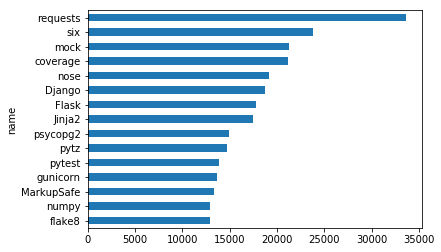

In [7]:
%matplotlib inline

# top most popular packages
df.groupby('name').size().nlargest(15).iloc[::-1].plot('barh')

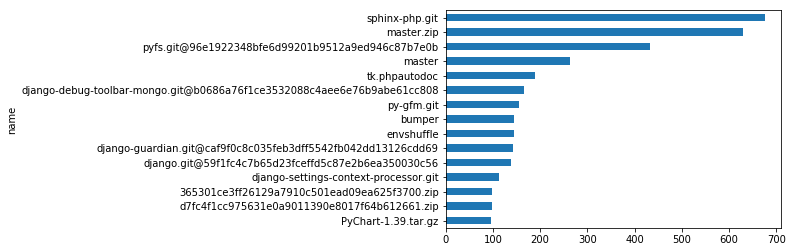

In [8]:
%matplotlib inline

# top most linked packages
df[df['url'].notnull()].groupby('name').size().nlargest(15).iloc[::-1].plot('barh')